### Loading data

In [1]:
def split_in_sets(data):
    essay_sets = []
    min_scores = []
    max_scores = []
    for s in range(1,9):
        essay_set = data[data["essay_set"] == s]
        essay_set.dropna(axis=1, inplace=True)
        n, d = essay_set.shape
        set_scores = essay_set["domain1_score"]
        print ("Set", s, ": Essays = ", n , "\t Attributes = ", d)
        min_scores.append(set_scores.min())
        max_scores.append(set_scores.max())
        essay_sets.append(essay_set)
    return (essay_sets, min_scores, max_scores)

In [2]:
%matplotlib inline

dataset_path = "./asap-aes/training_set_rel3.tsv"

import os
import pandas as pd

data = pd.read_csv(dataset_path, sep="\t", encoding="ISO-8859-1", index_col="essay_id")
min_scores = [2, 1, 0, 0, 0, 0, 0, 0]
max_scores = [12, 6, 3, 3, 4, 4, 30, 60]

essay_sets, data_min_scores, data_max_scores = split_in_sets(data)
set1, set2, set3, set4, set5, set6, set7, set8 = tuple(essay_sets)
data.dropna(axis=1, inplace=True)

data.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
print("All Data:", len(data))
data.head()


Set 1 : Essays =  1783 	 Attributes =  5
Set 2 : Essays =  1800 	 Attributes =  8
Set 3 : Essays =  1726 	 Attributes =  5
Set 4 : Essays =  1770 	 Attributes =  5
Set 5 : Essays =  1805 	 Attributes =  5
Set 6 : Essays =  1800 	 Attributes =  5
Set 7 : Essays =  1569 	 Attributes =  13
Set 8 : Essays =  723 	 Attributes =  17
All Data: 12976


,essay_set,essay,domain1_score
essay_id,,,
1,1,"Dear local newspaper, I think effects computer...",8
2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
5,1,"Dear @LOCATION1, I know having computers has a...",8


In [3]:
print("Minimum Scores: ", min_scores)
print("Maximum Scores: ", max_scores)

Minimum Scores:  [2, 1, 0, 0, 0, 0, 0, 0]
Maximum Scores:  [12, 6, 3, 3, 4, 4, 30, 60]


In [4]:
#Dataset keys
essay_id_key = "essay_id"
essay_set_key = "essay_set"
essay_key = "essay"
domain1_score_key = "domain1_score"

In [5]:
#Feature keys
feature_keys = {
    "char_count_key": "char_count",
    "word_count_key": "word_count",
    "diff_words_count_key": "diff_words_count",
    "word_count_root_key": "word_count_root",
    "sen_count_key": "sen_count",
    "avg_word_len_key": "avg_word_len",
    "avg_sen_len_key": "avg_sen_len",
    "l5_word_count_key": "l5_word_count",
    "l6_word_count_key": "l6_word_count",
    "l7_word_count_key": "l7_word_count",
    "l8_word_count_key": "l8_word_count",
}

In [6]:
#Extra features
extra_feature_keys = {
    # "grammer_error_count_key": "grammer_error_count",
    "spelling_error_count_key": "spelling_error_count",
    "stopwords_count_key": "stopwords_count",
    "small_sentences_count_key": "small_sentence_count", #sentences less than len 4
    # "beautiful_words_count_key": "beautiful_words_count",
    "punctuations_count_key": "punctuations_count",
    "verbs_count_key": "verbs_count",
    "adverbs_count_key": "adverbs_count",
    "nouns_count_key": "nouns_count",
    "adjectives_count_key": "adjective_count",
}

In [7]:
feature_keys_list = list(feature_keys.values())
extra_feature_keys_list = list(extra_feature_keys.values())
all_feature_keys_list = feature_keys_list + extra_feature_keys_list

print("Basic 11 features: ", feature_keys_list, "\n")
print("Extra features: ", extra_feature_keys_list, "\n")
print("All features: ", all_feature_keys_list, "\n")

Basic 11 features:  ['char_count', 'word_count', 'diff_words_count', 'word_count_root', 'sen_count', 'avg_word_len', 'avg_sen_len', 'l5_word_count', 'l6_word_count', 'l7_word_count', 'l8_word_count'] 

Extra features:  ['spelling_error_count', 'stopwords_count', 'small_sentence_count', 'punctuations_count', 'verbs_count', 'adverbs_count', 'nouns_count', 'adjective_count'] 

All features:  ['char_count', 'word_count', 'diff_words_count', 'word_count_root', 'sen_count', 'avg_word_len', 'avg_sen_len', 'l5_word_count', 'l6_word_count', 'l7_word_count', 'l8_word_count', 'spelling_error_count', 'stopwords_count', 'small_sentence_count', 'punctuations_count', 'verbs_count', 'adverbs_count', 'nouns_count', 'adjective_count'] 



In [8]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
import language_check
from spellchecker import SpellChecker
from collections import Counter
from nltk.tag.perceptron import PerceptronTagger

tagger=PerceptronTagger() # load outside
tool = language_check.LanguageTool('en-US')
spell = SpellChecker()
spell.word_frequency.load_words(["PERSON", "ORGANIZATION", "LOCATION", "DATE", "TIME", "MONEY", "PERCENT", "CAPS"])

def sentence_to_word_list(sentence, remove_stopwords):
    # Remove non letter from sentenece and stop words
    sen_char_count = 0
    sen_word_count = 0
    l5_sen_word_count = 0
    l6_sen_word_count = 0
    l7_sen_word_count = 0
    l8_sen_word_count = 0    
    sen_diff_words = set()
    ### Extra Features ###
    sen_verbs_count = 0
    sen_adverbs_count = 0
    sen_nouns_count = 0
    sen_adjectives_count = 0
    sen_spelling_error_count = 0
    sen_stopwords_count = 0
    is_small_sentence = 0

    stops = set(stopwords.words("english"))
    all_words = sentence.lower().split()

    # count= Counter([j for i,j in tagger.tag(all_words)])
    # sen_verbs_count = count['VB'] + count['VBG'] + count['VBP'] + count['VBN'] + count['VBZ']
    # sen_adverbs_count = count['RB'] + count['RBR'] + count['RBS']
    # sen_nouns_count = count['NN'] + count['NNS'] + count['NNPS'] + count['NNP']
    # sen_adjectives_count = count['JJ'] + count['JJR'] 

    kept_words = []


    if len(all_words) <= 4: is_small_sentence = 1

    
    misspelled = spell.unknown(all_words)
    sen_spelling_error_count = len(misspelled)

    for word in all_words:
        sen_char_count += len(word)
        sen_word_count += 1
        word_len = len(word)
        if word_len > 5:
            l5_sen_word_count += 1
        if word_len > 6:
            l6_sen_word_count += 1
        if word_len > 7:
            l7_sen_word_count += 1
        if word_len > 8:
            l8_sen_word_count += 1

        sen_diff_words.add(word)

        isStopword = word in stops
        if isStopword: sen_stopwords_count += 1

        if remove_stopwords and not isStopword:
            kept_words.append(word)
        else:
            kept_words.append(word)

    features = {
         feature_keys["char_count_key"]: sen_char_count,
         feature_keys["word_count_key"]: sen_word_count,
         feature_keys["l5_word_count_key"]: l5_sen_word_count,
         feature_keys["l6_word_count_key"]: l6_sen_word_count,
         feature_keys["l7_word_count_key"]: l7_sen_word_count,
         feature_keys["l8_word_count_key"]: l8_sen_word_count,
         feature_keys["diff_words_count_key"]: sen_diff_words
    }

    extra_features = {
        extra_feature_keys["small_sentences_count_key"]: is_small_sentence,
        extra_feature_keys["spelling_error_count_key"]: sen_spelling_error_count,
        extra_feature_keys["stopwords_count_key"]: sen_stopwords_count,
        extra_feature_keys["verbs_count_key"]: sen_verbs_count,
        extra_feature_keys["adverbs_count_key"]: sen_adverbs_count,
        extra_feature_keys["nouns_count_key"]: sen_nouns_count,
        extra_feature_keys["adjectives_count_key"]: sen_adjectives_count,
    }

    return (kept_words, features, extra_features)

def essay_to_sentences(essay, remove_stopwords = False):
    # Convert essay into sentence
    

    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    sentences = tokenizer.tokenize(essay.strip())
    split_sentences = []

    char_count = 0
    word_count = 0
    diff_words = set()
    word_count_root = 0
    sen_count = 0
    avg_word_len = 0
    avg_sen_len = 0
    l5_word_count = 0
    l6_word_count = 0
    l7_word_count = 0
    l8_word_count = 0    
    

    ### Extra Features ###
    spelling_error_count = 0
    stopwords_count = 0
    small_sentences_count = 0
    punctuation_count = 0
    grammer_error_count = 0
    small_sentences_count = 0
    verbs_count = 0
    adverbs_count = 0
    nouns_count = 0
    adjectives_count = 0
 
    all_words = nltk.word_tokenize(essay)
    count= Counter([j for i,j in tagger.tag(all_words)])
    verbs_count = count['VB'] + count['VBG'] + count['VBP'] + count['VBN'] + count['VBZ']
    adverbs_count = count['RB'] + count['RBR'] + count['RBS']
    nouns_count = count['NN'] + count['NNS'] + count['NNPS'] + count['NNP']
    adjectives_count = count['JJ'] + count['JJR'] 

    punctuation = ['.','?', '!', ':', ';']
    for punct in punctuation:
        punctuation_count += essay.count(punct)
    
    for sentence in sentences:
        if len(sentence) > 0:
            sentence = re.sub("[^a-zA-Z]", " ", sentence)
            # grammer_error_count += len(tool.check(sentence))
            

            kept_words, features, extra_features = sentence_to_word_list(sentence, remove_stopwords)
            split_sentences.append(kept_words)
            
            sen_count +=1
            char_count += features[feature_keys["char_count_key"]]
            word_count += features[feature_keys["word_count_key"]]
            l5_word_count += features[feature_keys["l5_word_count_key"]]
            l6_word_count += features[feature_keys["l6_word_count_key"]]
            l7_word_count += features[feature_keys["l7_word_count_key"]]
            l8_word_count += features[feature_keys["l8_word_count_key"]]
            diff_words = diff_words|features[feature_keys["diff_words_count_key"]]
            ### Extra Features ###
            spelling_error_count += extra_features[extra_feature_keys["spelling_error_count_key"]]
            stopwords_count += extra_features[extra_feature_keys["stopwords_count_key"]]
            small_sentences_count += extra_features[extra_feature_keys["small_sentences_count_key"]]
            # verbs_count += extra_features[extra_feature_keys["verbs_count_key"]]
            # adverbs_count += extra_features[extra_feature_keys["adjectives_count_key"]]
            # nouns_count += extra_features[extra_feature_keys["nouns_count_key"]]
            # adjectives_count += extra_features[extra_feature_keys["adjectives_count_key"]]


    word_count_root = word_count ** (1/4)
    avg_word_len = char_count / word_count
    avg_sen_len = word_count / sen_count

    features = {
        feature_keys["char_count_key"]: char_count,
        feature_keys["word_count_key"]: word_count,
        feature_keys["diff_words_count_key"]: len(diff_words),
        feature_keys["word_count_root_key"]: word_count_root,
        feature_keys["sen_count_key"]: sen_count,
        feature_keys["avg_word_len_key"]: avg_word_len,
        feature_keys["avg_sen_len_key"]: avg_sen_len,
        feature_keys["l5_word_count_key"]: l5_word_count,
        feature_keys["l6_word_count_key"]: l6_word_count,
        feature_keys["l7_word_count_key"]: l7_word_count,
        feature_keys["l8_word_count_key"]: l8_word_count
    }

    extra_features = {
        # extra_feature_keys["grammer_error_count_key"]: grammer_error_count,
        extra_feature_keys["spelling_error_count_key"]: spelling_error_count,
        extra_feature_keys["stopwords_count_key"]: stopwords_count,
        extra_feature_keys["small_sentences_count_key"]: small_sentences_count,
        extra_feature_keys["punctuations_count_key"]: punctuation_count,
        extra_feature_keys["verbs_count_key"]: verbs_count,
        extra_feature_keys["adverbs_count_key"]: adverbs_count,
        extra_feature_keys["nouns_count_key"]: nouns_count,
        extra_feature_keys["adjectives_count_key"]: adjectives_count
    }

    return (split_sentences, features, extra_features)


In [9]:
import pprint
from time import time 

pp = pprint.PrettyPrinter(indent=4)

#Featrues
first_essay = data.iloc[0][essay_key]
print(first_essay)
start = time()
split_sentences, features, extra_features = essay_to_sentences(first_essay)
end = time()
print("Execution time:", end-start)
# print(split_sentences)
print("\n\nFeatures: ")
pp.pprint(features)

print("\n\n Extra Features: ")
pp.pprint(extra_features)


Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the economy

In [10]:
def makeDataFrame(data):
    all_features = {}
    all_scores = {}

    for row in range(len(data)):
        if row % 1500 == 0 and row != 0: print("Processed ", row, " essays of", len(data), " rows.")
        essay_data = data.iloc[row]
        essay = essay_data[essay_key]
        # essay_id = essay_data[essay_id_key]
        essay_id = essay_data.name
        essay_score = essay_data[domain1_score_key]
        _, features, extra_features = essay_to_sentences(essay)

        combined_features = {}
        combined_features.update(features)
        combined_features.update(extra_features)
        all_features[essay_id] = combined_features
        all_scores[essay_id] = essay_score

    X = pd.DataFrame.from_dict(all_features, orient="index")
    y = pd.DataFrame.from_dict(all_scores, orient="index")

    return(X, y)


In [11]:
from time import time 
start = time()
X, y = makeDataFrame(data)
end = time()
print("Execution time to make dataframe ", (end-start)/60, " mins")

Processed  1500  essays of 12976  rows.
Processed  3000  essays of 12976  rows.
Processed  4500  essays of 12976  rows.
Processed  6000  essays of 12976  rows.
Processed  7500  essays of 12976  rows.
Processed  9000  essays of 12976  rows.
Processed  10500  essays of 12976  rows.
Processed  12000  essays of 12976  rows.
Execution time to make dataframe:  349.12322187423706


In [12]:
# Features for essay
print(len(X))
X.head()

12976


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,l8_word_count,spelling_error_count,stopwords_count,small_sentence_count,punctuations_count,verbs_count,adverbs_count,nouns_count,adjective_count
1,1478,350,164,4.325308,16,4.222857,21.875000,74,59,34,13,9,184,3,17,67,21,84,22
2,1814,423,192,4.535081,20,4.288416,21.150000,106,80,53,26,17,199,0,20,77,18,114,20
3,1222,283,147,4.101537,14,4.318021,20.214286,78,53,32,19,2,147,1,14,52,14,86,18
4,2510,530,232,4.798096,27,4.735849,19.629630,169,128,84,52,27,228,1,27,82,28,197,46
5,2046,473,200,4.663535,30,4.325581,15.766667,128,87,57,34,11,249,0,30,85,36,116,31


In [13]:
# Score labels
y.head()

,0
1,8
2,9
3,7
4,10
5,8


In [14]:
X_basic = X[feature_keys_list]
X_basic.head()

,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,l8_word_count
1,1478,350,164,4.325308,16,4.222857,21.875000,74,59,34,13
2,1814,423,192,4.535081,20,4.288416,21.150000,106,80,53,26
3,1222,283,147,4.101537,14,4.318021,20.214286,78,53,32,19
4,2510,530,232,4.798096,27,4.735849,19.629630,169,128,84,52
5,2046,473,200,4.663535,30,4.325581,15.766667,128,87,57,34


In [33]:
# Training on features using linear regression
from time import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import cohen_kappa_score as kappa
import matplotlib.pyplot as plt
from datetime import datetime

def evaluate(X, y, model = LinearRegression(), plot=False):

    # Use train test split to get test set
    # Then split into train and val
    X, X_unseen, y, y_unseen = train_test_split(X, y, test_size=0.1, random_state=1)
    
    #Simple K-Fold cross validation. 5 folds.
    kf = KFold(n_splits=5, shuffle=True)
    cv = kf.split(X)
    results = []
    
    start = time()

    for traincv, testcv in cv:
            X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
                                        
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            y_pred = y_pred.reshape(-1)
        #     y_pred = [item for sublist in y_pred for item in sublist]
            y_pred = np.around(y_pred, decimals=0).astype(int)
            y_test = [item for sublist in y_test.values for item in sublist]
        
            result = kappa(y_test,y_pred,labels=None, weights='quadratic')
            results.append(result)

    end = time()
    print("Train time ", round((end-start)/60, 3), " mins")
    if plot:
        y_unseen_pred = model.predict(X_unseen)
        y_unseen_pred = y_unseen_pred.reshape(-1)
        y_unseen_pred = np.around(y_unseen_pred, decimals=0).astype(int)
        # print(X_unseen.shape)
        # print(y_unseen.shape)
        labels = set(y_unseen_pred)
        ncol = int(len(labels)/2.5)
        plt.figure(figsize=(8, 8))
        scatter = plt.scatter(X_unseen.index,y_unseen, c=y_unseen_pred)
        handles = scatter.legend_elements()[0]
        plt.legend(handles=handles, labels=labels, ncol=ncol, loc="lower right")
        plt.ylabel("Score")
        plt.xlabel("Essay ID")
        model_name = type(model).__name__
        plt.title("Model: " + model_name)

        dateTimeObj = datetime.now()
        timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S.%f)")

        plt.savefig("./figs/" + model_name + "-" +timestampStr + ".png")
    return (np.array(results).mean())


In [16]:
# linr = LinearRegression()
# svm = SVC(kernel="linear", C=0.025)
# knn = KNeighborsClassifier(10)
# all_classifiers = [linr, svm, knn]
# classifiers = [linr, knn]

def get_classifiers():
    linr = LinearRegression()
    knn = KNeighborsClassifier(10)
    return [linr, knn]

def get_all_classifiers():
    linr = LinearRegression()
    svm = SVC(kernel="linear", C=0.025)
    knn = KNeighborsClassifier(10)
    return [linr, svm, knn]

In [19]:
# Using all data set
# Linear Regression
print("Evaluation using basic 11 features (All Essays)")
for classifier in get_classifiers():
    np.random.seed(1)
    print("Model:", type(classifier).__name__)
    k = evaluate(X_basic, y, classifier)
    print("Mean Quadratic Kappa Score:", k)
    print()

Evaluation using basic 11 features (All Essays)
Model: LinearRegression
Train time  0.002  mins
Mean Quadratic Kappa Score: 0.7470108772429251

Model: KNeighborsClassifier
Train time  0.025  mins
Mean Quadratic Kappa Score: 0.6207298517983044



In [21]:
# np.random.seed(1)
# print("Evaluation using all features")
# k = evaluate(X, y)
# print("Kappa Score (all essays):", k)
%matplotlib inline

print("Evaluation using all features (All Essays)")
for classifier in get_classifiers():
    np.random.seed(1)
    print("Model:", type(classifier).__name__)
    k = evaluate(X, y, classifier)
    print("Mean Quadratic Kappa Score:", k)
    print()


Evaluation using all features (All Essays)
Model: LinearRegression
Train time  0.002  mins
Mean Quadratic Kappa Score: 0.8220726493506044

Model: KNeighborsClassifier
Train time  0.021  mins
Mean Quadratic Kappa Score: 0.6512972872681229



In [23]:
X_sets = []
y_sets = []
essay_sets = [set1, set2, set3, set4, set5, set6, set7, set8]
for set_no in range(8):
    # X_set, y_set = makeDataFrame(essay_sets[set_no])
    X_set, y_set = X.loc[X.index & essay_sets[set_no].index], y.loc[y.index & essay_sets[set_no].index]
    print("Set", (set_no+1), " X len:", len(X_set), " Y len:", len(y_set))
    X_sets.append(X_set)
    y_sets.append(y_set)    

Set 1  X len: 1783  Y len: 1783
Set 2  X len: 1800  Y len: 1800
Set 3  X len: 1726  Y len: 1726
Set 4  X len: 1770  Y len: 1770
Set 5  X len: 1805  Y len: 1805
Set 6  X len: 1800  Y len: 1800
Set 7  X len: 1569  Y len: 1569
Set 8  X len: 723  Y len: 723


All features ( Model:  LinearRegression )
Train time  0.001  mins
Mean Quadratic Kappa Score - Set 1: 0.842239862997365
All features ( Model:  SVC )
Train time  0.465  mins
Mean Quadratic Kappa Score - Set 1: 0.8087481771337593
All features ( Model:  KNeighborsClassifier )
Train time  0.002  mins
Mean Quadratic Kappa Score - Set 1: 0.7869545642267217


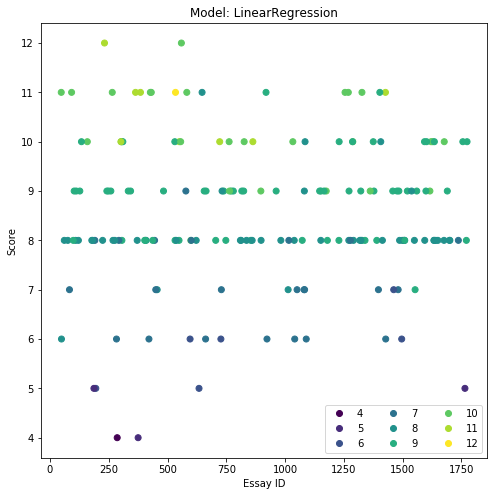

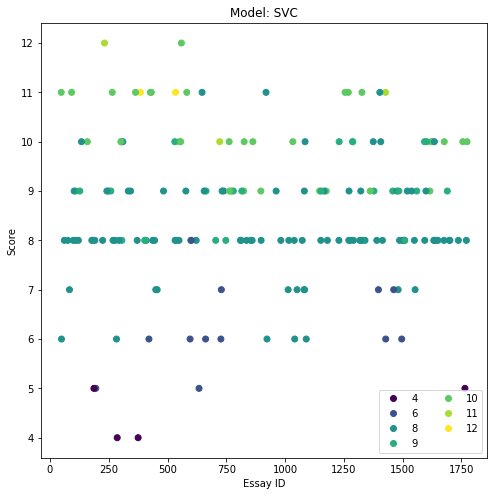

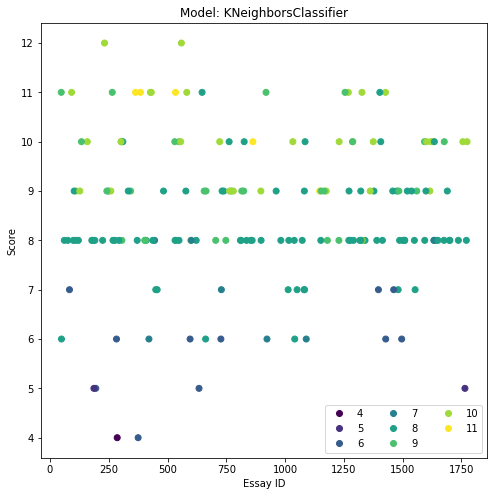

In [34]:
for classifier in get_all_classifiers():
    print("All features ( Model: ", type(classifier).__name__, ")")
    np.random.seed(1)
    X_set, y_set = X_sets[0], y_sets[0]
    print("Mean Quadratic Kappa Score - Set 1:", evaluate(X_set, y_set, classifier, plot=True))

In [35]:
# Training on individual dataset
for classifier in get_all_classifiers():
    print("Basic 11 features ( Model: ", type(classifier).__name__, ")")
    for set_no in range(8):
        np.random.seed(1)
        X_basic_set, y_set = X_sets[set_no][feature_keys_list], y_sets[set_no]
        print("Mean Quadratic Kappa Score - Set", (set_no+1), ":", evaluate(X_basic_set, y_set, classifier))
    print()

Basic 11 features ( Model:  LinearRegression )
Train time  0.001  mins
Mean Quadratic Kappa Score - Set 1 : 0.838822982103871
Train time  0.002  mins
Mean Quadratic Kappa Score - Set 2 : 0.6912134276433134
Train time  0.001  mins
Mean Quadratic Kappa Score - Set 3 : 0.6438197349869839
Train time  0.001  mins
Mean Quadratic Kappa Score - Set 4 : 0.6887919633681174
Train time  0.001  mins
Mean Quadratic Kappa Score - Set 5 : 0.7777263038294968
Train time  0.0  mins
Mean Quadratic Kappa Score - Set 6 : 0.662567636397427
Train time  0.001  mins
Mean Quadratic Kappa Score - Set 7 : 0.7302615499472598
Train time  0.001  mins
Mean Quadratic Kappa Score - Set 8 : 0.7241454841800593

Basic 11 features ( Model:  SVC )
Train time  0.407  mins
Mean Quadratic Kappa Score - Set 1 : 0.797217900501633
Train time  1.076  mins
Mean Quadratic Kappa Score - Set 2 : 0.6411664157802055
Train time  0.134  mins
Mean Quadratic Kappa Score - Set 3 : 0.6937116990062464
Train time  0.34  mins
Mean Quadratic Kappa

In [36]:
for classifier in get_all_classifiers():
    print("All features ( Model: ", type(classifier).__name__, ")")
    for set_no in range(8):
        np.random.seed(1)
        X_set, y_set = X_sets[set_no], y_sets[set_no]
        print("Mean Quadratic Kappa Score - Set", (set_no+1), ":", evaluate(X_set, y_set, classifier))
    print()

All features ( Model:  LinearRegression )
Train time  0.002  mins
Mean Quadratic Kappa Score - Set 1 : 0.842239862997365
Train time  0.001  mins
Mean Quadratic Kappa Score - Set 2 : 0.6977488935351792
Train time  0.001  mins
Mean Quadratic Kappa Score - Set 3 : 0.6458010523959329
Train time  0.001  mins
Mean Quadratic Kappa Score - Set 4 : 0.6879835761852089
Train time  0.001  mins
Mean Quadratic Kappa Score - Set 5 : 0.775330263130033
Train time  0.001  mins
Mean Quadratic Kappa Score - Set 6 : 0.6777655888684742
Train time  0.001  mins
Mean Quadratic Kappa Score - Set 7 : 0.7702965489182455
Train time  0.001  mins
Mean Quadratic Kappa Score - Set 8 : 0.7265795258728722

All features ( Model:  SVC )
Train time  0.518  mins
Mean Quadratic Kappa Score - Set 1 : 0.8087481771337593
Train time  0.865  mins
Mean Quadratic Kappa Score - Set 2 : 0.6697487027084275
Train time  0.166  mins
Mean Quadratic Kappa Score - Set 3 : 0.6873761900077291
Train time  0.332  mins
Mean Quadratic Kappa Score

In [37]:
# Hyper paramter tuning SVM
print("Parameter tuning for SVM - Set 1")
Cs = [0.025, 0.05, 0.1, 0.5, 0.9]
for C in Cs:
    svm = SVC(kernel="linear", C=C)
    np.random.seed(1)
    k = evaluate(X_sets[0], y_sets[0], svm)
    print("C:", C, " Mean Quadratic Kappa Score:", k)
print()

print("Paramter tuning for KNN - Set 1")
NNs = [10, 15, 25, 30]
for nn in NNs:
    knn = KNeighborsClassifier(nn)
    np.random.seed(1)
    k = evaluate(X_sets[0], y_sets[0], knn)
    print("NN:", nn, " Mean Quadratic Kappa Score:", k)
print()

Parameter tuning for SVM - Set 1
Train time  0.473  mins
C: 0.025  Mean Quadratic Kappa Score: 0.7923569327281237
Train time  0.797  mins
C: 0.05  Mean Quadratic Kappa Score: 0.8075148605007936
Train time  1.497  mins
C: 0.1  Mean Quadratic Kappa Score: 0.8043914888855314
Train time  5.714  mins
C: 0.5  Mean Quadratic Kappa Score: 0.8000244524749484
Train time  6.994  mins
C: 0.9  Mean Quadratic Kappa Score: 0.8102587665584526

Paramter tuning for KNN - Set 1
Train time  0.002  mins
NN: 10  Mean Quadratic Kappa Score: 0.7905440222658482
Train time  0.002  mins
NN: 15  Mean Quadratic Kappa Score: 0.791380264670927
Train time  0.003  mins
NN: 25  Mean Quadratic Kappa Score: 0.792644446373451
Train time  0.002  mins
NN: 30  Mean Quadratic Kappa Score: 0.7953246180996105



In [47]:
feature_kapps = []
for feature in all_feature_keys_list:
    X_feat = X_sets[0][[feature]]
    y_feat = y_sets[0]
    np.random.seed(1)
    k_feat = evaluate(X_feat, y_feat)
    feature_kapps.append((feature, k_feat))

feature_kapps.sort(key = lambda x:  -x[1])
for feature_kappa in feature_kapps:
    print(feature_kappa)

Train time  0.002  mins
Train time  0.001  mins
Train time  0.001  mins
Train time  0.0  mins
Train time  0.0  mins
Train time  0.0  mins
Train time  0.0  mins
Train time  0.001  mins
Train time  0.001  mins
Train time  0.0  mins
Train time  0.0  mins
Train time  0.0  mins
Train time  0.0  mins
Train time  0.001  mins
Train time  0.001  mins
Train time  0.0  mins
Train time  0.0  mins
Train time  0.0  mins
Train time  0.0  mins
('word_count_root', 0.7960980410286996)
('diff_words_count', 0.7954901398458507)
('char_count', 0.7910115897794633)
('word_count', 0.7583759316924319)
('l5_word_count', 0.7553904289450902)
('l6_word_count', 0.746746155504795)
('nouns_count', 0.7376250693553479)
('l7_word_count', 0.7035481330589399)
('stopwords_count', 0.6763578000752763)
('verbs_count', 0.6603630069783022)
('adjective_count', 0.6457466423246295)
('sen_count', 0.6401569173193834)
('punctuations_count', 0.6366138500748759)
('l8_word_count', 0.6000779049092994)
('adverbs_count', 0.5320857870070199)

In [49]:
feature_kapps = []
for feature in all_feature_keys_list:
    np.random.seed(1)
    k_feat = evaluate(X[[feature]], y)
    feature_kapps.append((feature, k_feat))
    
feature_kapps.sort(key = lambda x:  -x[1])
for feature_kappa in feature_kapps:
    print(feature_kappa)

Train time  0.003  mins
Train time  0.002  mins
Train time  0.001  mins
Train time  0.003  mins
Train time  0.002  mins
Train time  0.001  mins
Train time  0.002  mins
Train time  0.003  mins
Train time  0.001  mins
Train time  0.001  mins
Train time  0.001  mins
Train time  0.003  mins
Train time  0.003  mins
Train time  0.001  mins
Train time  0.001  mins
Train time  0.002  mins
Train time  0.001  mins
Train time  0.001  mins
Train time  0.001  mins
('punctuations_count', 0.5506910739234592)
('sen_count', 0.530954786173018)
('adverbs_count', 0.5179908984934892)
('stopwords_count', 0.5130495712821135)
('word_count', 0.5116260467573699)
('diff_words_count', 0.502868069554857)
('adjective_count', 0.470870606093578)
('char_count', 0.45132609669086265)
('word_count_root', 0.4461595319028861)
('nouns_count', 0.4456908660198316)
('l5_word_count', 0.3274018878576128)
('verbs_count', 0.2899716150221348)
('l6_word_count', 0.25525098477480274)
('avg_word_len', 0.24486383580916687)
('small_sente

In [53]:
top_features = feature_kapps[:4]

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
axs = [ax1, ax2, ax3, ax4]
for i in range(len(top_features)):
    ax = axs[i]
    top_feature = top_features[i]
    ax.scatter(X[[top_feature[0]]],y)
    ax.set_ylabel('Score')
    ax.set_xlabel(top_feature)
    ax.set_title("Score v " + top_feature[0] + " : " + str(top_feature[1]))

fig.savefig('./figs/ScoreVFeature.png', bbox_inches = "tight")







FileNotFoundError: [Errno 2] No such file or directory: './fig/ScoreVFeature.png'

In [117]:
print("Mean of features:")
X.mean(axis=0)

Mean of features:


char_count              952.516954
word_count              225.458154
diff_words_count        108.591862
word_count_root           3.666353
sen_count                12.716091
avg_word_len              4.236917
avg_sen_len              20.565670
l5_word_count            53.798166
l6_word_count            35.832306
l7_word_count            21.270962
l8_word_count            11.555256
spelling_error_count      4.819744
stopwords_count         118.090244
small_sentence_count      0.437962
punctuations_count       13.717787
verbs_count              36.444436
adverbs_count            13.360897
nouns_count              56.080996
adjective_count          15.469097
dtype: float64

In [119]:
print("Deviation of features:")
X.std(axis=0)

Deviation of features:


char_count              745.525805
word_count              178.681107
diff_words_count         64.705354
word_count_root           0.726777
sen_count                11.151927
avg_word_len              0.355270
avg_sen_len              12.388588
l5_word_count            43.060338
l6_word_count            29.229100
l7_word_count            19.037364
l8_word_count            11.194151
spelling_error_count      4.807119
stopwords_count          95.585648
small_sentence_count      1.364738
punctuations_count       13.106078
verbs_count              32.863780
adverbs_count            13.279126
nouns_count              44.943184
adjective_count          13.754006
dtype: float64